In [61]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

from survae import SurVAE, DEVICE
from survae.data import SIR_Basic, SIR_Degenerate
from survae.layer import *
from survae.calibrate import *

import json

# Standard SIR (repetition of ex04.1)

This section takes inspiration from the sample solution of exercise sheet 04: https://mampf.mathi.uni-heidelberg.de/mediaforward/medium/45620/manuscript/f4c55a7f4b503f756d1022b45bcdedd5.pdf/ex04_solutions.pdf

In [2]:
SAVE_PATH = "./saves/sv_sbi"

In [3]:
sir_basic_dataset = SIR_Basic()

### Figure out good summary network size

This section is broken due to structural changes in the rest of the notebook. If you want to run it, take an earlier version of the notebook from the repo.

In [ ]:
def train_ffnn(model, X, y, batch_size, epochs, lr=1e-3):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    mse = nn.MSELoss()

    log = {
        'loss_train': [],
    }

    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()

        r = torch.randperm(len(X))
        x_train = X[r][:batch_size]
        y_train = y[r][:batch_size]

        z = model(y_train)

        loss = mse(z, x_train)
        loss.backward()

        optimizer.step()
        log['loss_train'].append(loss.item())

    return log

In [ ]:
Y_train = sample_Y(100_000)
X_train = simulate_sir_simple(Y_train)

In [ ]:
hyp_hidden_sizes = [(16, 16), (32, 32), (64, 64), (128, 128), (256, 256)]

fns = [FFNN(200, hidden_sizes, 3) for hidden_sizes in hyp_hidden_sizes]

In [ ]:
for fn in fns:
    train_ffnn(fn, Y_train, X_train, 1000, 3000)

In [ ]:
Y_val = sample_Y(1_000)
X_val = simulate_sir_simple(Y_val)

In [ ]:
width = Y_val.shape[-1]
height = len(hyp_hidden_sizes)

param_names = (r"$\lambda$", r"$\mu$", r"$I_0$")

fig, ax = plt.subplots(height, width, figsize=(3*width, 3*height))

for k in range(height):
    Y_hat = fns[k](X_val)

    for i in range(width):
        _ax = ax[k][i]
        _ax.scatter(Y_val[:, i].detach().cpu().numpy(), Y_hat[:, i].detach().cpu().numpy(), s=1)

        _ax.set_title(f'Param: {param_names[i]}, size: {hyp_hidden_sizes[k]}')
        _ax.set_xlabel('Ground truth')
        _ax.set_ylabel('Prediction')

plt.axis('equal')
plt.tight_layout()
plt.show()

We choose hidden size (64, 64) for the remainder of the notebook.

### Train NF

In [4]:
sv_sir_basic = SurVAE(
    [
        [BijectiveLayer(3, [150, 150]), OrthonormalLayer(3)]
        for _ in range(30)
    ],
    name="NF",
    condition_size=100,
    summary=FFNN(200, [200, 200], 100),
)

In [5]:
train_log = sv_sir_basic.train(
    dataset = sir_basic_dataset,
    batch_size = 200,
    test_size  = 1_000,
    epochs     = 2_000,
    lr         = 5e-3,
    log_period = 100,
    use_one_hot = False,
    lr_decay_params={'gamma': 0.9, 'step_size': 50},
    show_tqdm=True,
    save_path=SAVE_PATH,
    record_std=True,
)

100%|██████████| 2000/2000 [15:29<00:00,  2.15it/s]


In [ ]:
5e-3 * (0.9) ** (2_000 / 50)

## Plot loss

In [6]:
times = list(train_log.keys())
loss_train = [m.training_loss for m in train_log.values()]
loss_test = [m.testing_loss for m in train_log.values()]
sigmas = [m.sigma for m in train_log.values()]

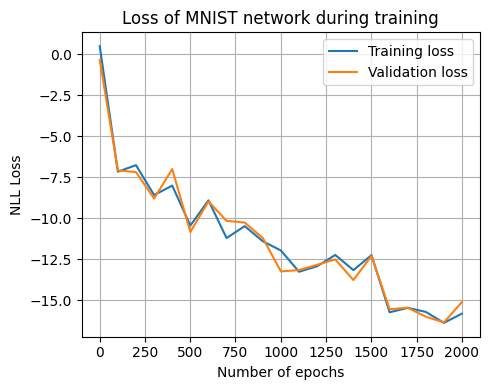

In [7]:
plt.figure(figsize=(5, 4))

plt.plot(times, loss_train, label='Training loss')
plt.plot(times, loss_test, label='Validation loss')

plt.title('Loss of MNIST network during training')
plt.xlabel('Number of epochs')
plt.ylabel('NLL Loss')

plt.grid()
# plt.ylim(0, 1e7)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# save loss values & sigma
with open(SAVE_PATH + "/output/loss_test.txt", "w") as f:
    json.dump(loss_test, f, indent=0)

with open(SAVE_PATH + "/output/loss_train.txt", "w") as f:
    json.dump(loss_train, f, indent=0)

with open(SAVE_PATH + "/output/sigmas.txt", "w") as f:
    json.dump(sigmas, f, indent=0)

Introducing learning rate decay massively increased training quality and stability.

## Perform checks

### Plot code distribution

In [9]:
X, y = sir_basic_dataset.sample(10_000, labels=True)

with torch.no_grad():
    Z = sv_sir_basic(X, y).cpu()

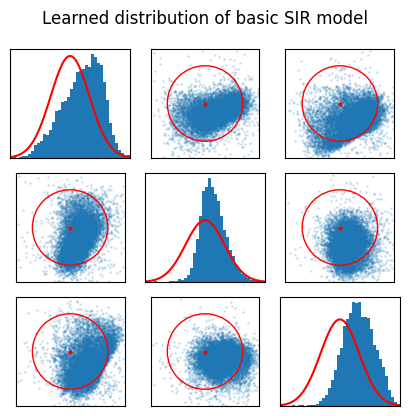

In [56]:
plot_learned_distribution(Z, f"Learned distribution of basic SIR model", plotsize=1.4, axis_scale=3.1)

### Plot calibration diagrams

In [11]:
X, y = sir_basic_dataset.sample(100, labels=True)
cs = compute_calibration_values(sv_sir_basic, X, y, 40)

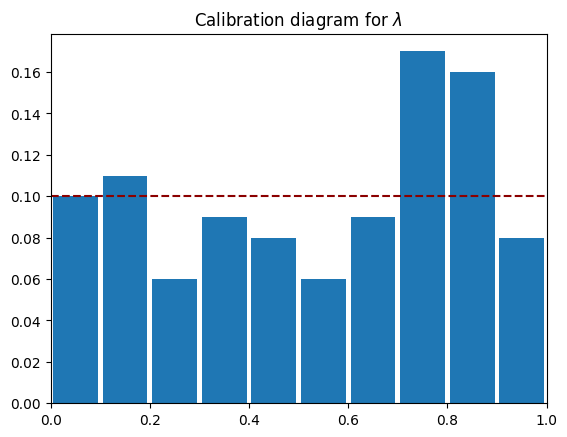

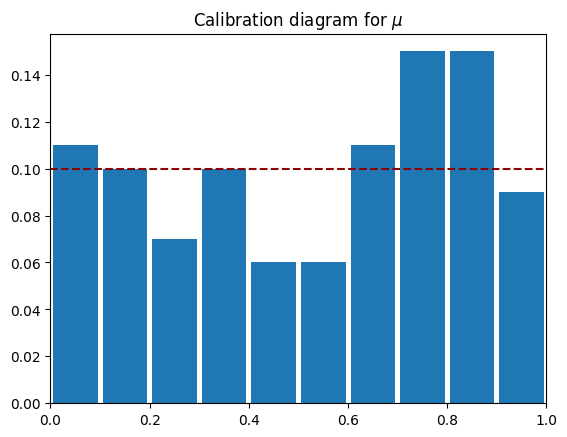

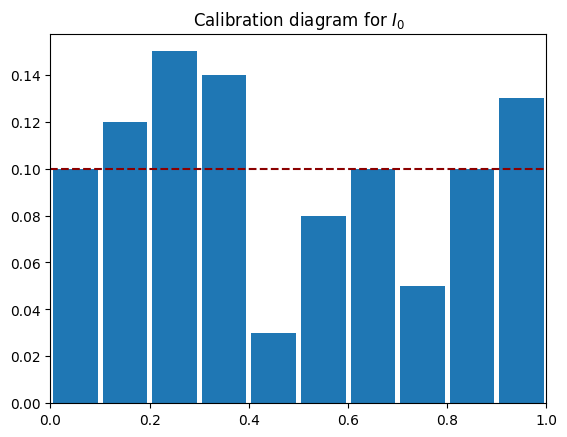

In [12]:
plot_calibration_history(cs[0], 10, r"Calibration diagram for $\lambda$")
plot_calibration_history(cs[1], 10, r"Calibration diagram for $\mu$")
plot_calibration_history(cs[2], 10, r"Calibration diagram for $I_0$")

### Resimulation

In [119]:
# Resimulate for a handful of values
n_resims = 3
n_samples = 463

X, y = sir_basic_dataset.sample(n_resims, labels=True)
y_resim, X_resim = resimulate(sv_sir_basic, sir_basic_dataset._simulate, X, n_samples=n_samples, return_samples=True)

# Reshape data into dS and dR
y = y.reshape(n_resims, 100, 2)
y_resim = y_resim.reshape(n_resims, n_samples, 100, 2)

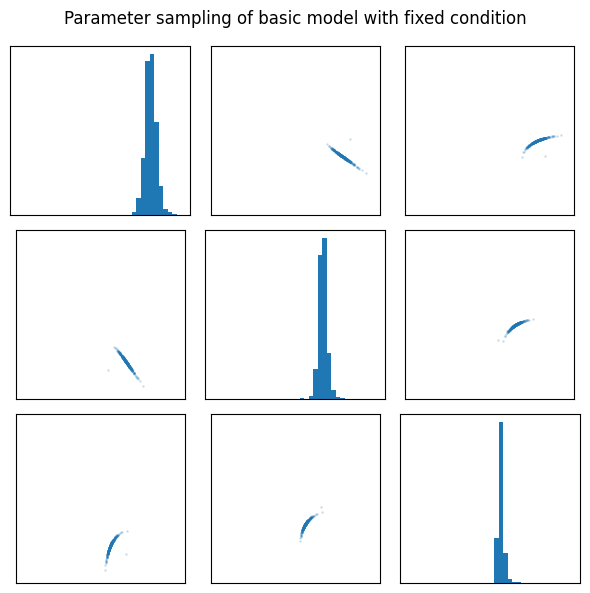

In [120]:
plot_learned_distribution(X_resim[0].cpu(), "Parameter sampling of basic model with fixed condition", axis_scale=1, plot_gaussian=False)

In [30]:
# Check if any 'nan' values show up in the resimulation.
# They indicate that the parameters generated by the model are
# non-sensical for the simulation at hand.

n_nan = y_resim.isnan().sum().item()
n_total = torch.prod(torch.tensor(y_resim.shape)).item()

print(f"Number of 'nan' values in resimulation: {n_nan} ({n_nan / n_total * 100:6.02f}%)")


Number of 'nan' values in resimulation: 0 (  0.00%)


In [54]:
def plot_resimulation(GT: torch.Tensor, X_resim: torch.Tensor, **kwargs):
    '''
    Plot data produced by "resimulate". The two functions are separate to allow for data cleanup of the resimulation output.
    The kwargs are passed to "plt.figure".

    ### Inputs:
    * GT: Ground-truth simulation which was resimulated. Has shape (D, 2).
    * X_resim: Resimulation data. Has shape (N_SAMPLES, D, 2).
    '''
    GT = GT.cumsum(dim=0)
    X_resim = X_resim.cumsum(dim=1)

    means = X_resim.mean(dim=0).cpu().numpy()
    quantiles = X_resim.quantile(torch.tensor([0.025, 0.975]), dim=0).cpu().numpy()
    _x = np.arange(len(GT))

    plt.figure(**kwargs)
    plt.fill_between(_x, quantiles[0, :, 0], quantiles[1, :, 0], alpha=0.2, color='orange', label='S 95%')
    plt.plot(_x, means[:, 0], linestyle='--', alpha=0.8, color='orange', label='S Mean')
    plt.plot(_x, GT[:, 0].cpu().numpy(), color='orange', label='S Ground truth')
    plt.fill_between(_x, quantiles[0, :, 1], quantiles[1, :, 1], alpha=0.2, color='blue', label='R 95%')
    plt.plot(_x, means[:, 1], linestyle='--', alpha=0.8, color='blue', label='R Mean')
    plt.plot(_x, GT[:, 1].cpu().numpy(), color='blue', label='R Ground truth')

    plt.legend(bbox_to_anchor=(1, 1))
    plt.grid()
    plt.show()

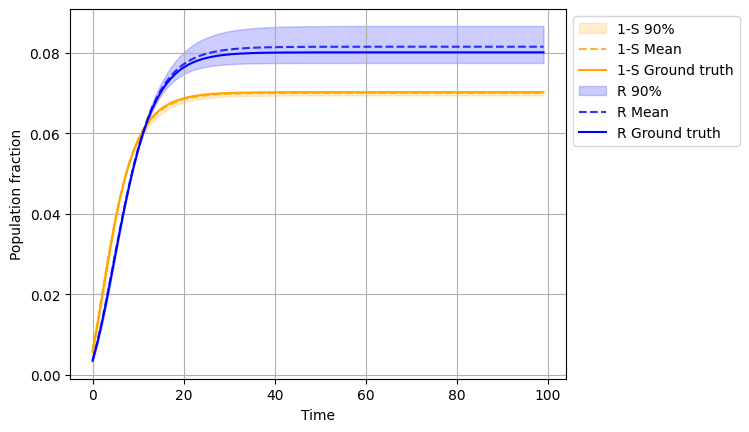

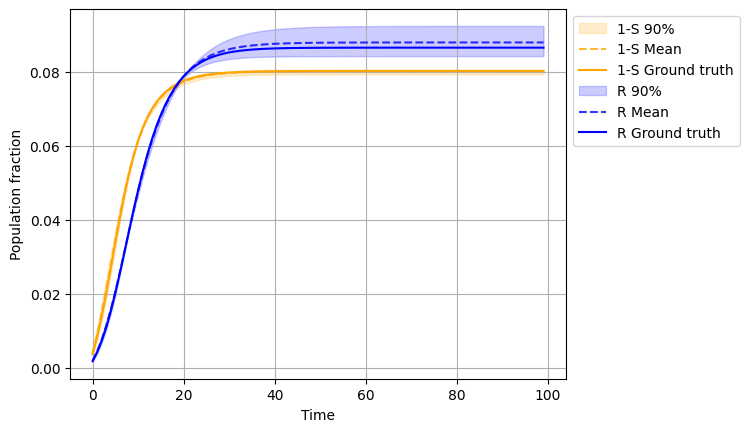

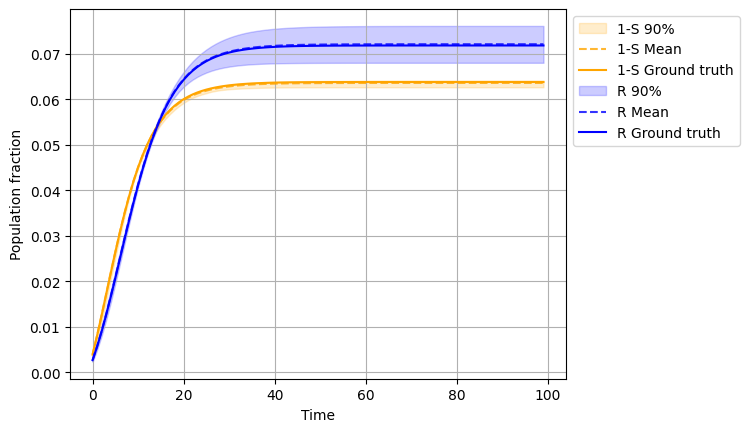

In [121]:
for _y, _y_resim in zip(y, y_resim):
    plot_resimulation(_y, _y_resim)

# Parameter-degenerate SIR

Here, the SIR model has two lambda values that are summed during simulation so as to not be unambiguously recoverable.

In [59]:
SAVE_PATH = "./saves/sv_sbi_degen"

In [62]:
sir_degen_dataset = SIR_Degenerate()

### Figure out good summary network size

This section is broken due to structural changes in the rest of the notebook. If you want to run it, take an earlier version of the notebook from the repo.

In [ ]:
Y_train_degen = sample_Y_degen(100_000)
X_train_degen = simulate_sir_simple_degen(Y_train_degen)

In [ ]:
# hyp_hidden_sizes = [(16, 16), (32, 32), (64, 64), (128, 128), (256, 256)]
hyp_hidden_sizes = [(64, 64), (200, 200), (200, 200, 100)]

fns = [FFNN(200, hidden_sizes, 4) for hidden_sizes in hyp_hidden_sizes]

In [ ]:
for fn in fns:
    train_ffnn(fn, Y_train_degen, X_train_degen, 1000, 3000)

In [ ]:
Y_val_degen = sample_Y_degen(1_000)
X_val_degen = simulate_sir_simple_degen(Y_val_degen)

In [ ]:
width = Y_val.shape[-1]
height = len(hyp_hidden_sizes)

param_names = (r"$\lambda_1$", r"$\lambda_2$", r"$\mu$", r"$I_0$")

fig, ax = plt.subplots(height, width, figsize=(3*width, 3*height))

for k in range(height):
    Y_hat = fns[k](X_val_degen)

    for i in range(width):
        _ax = ax[k][i]
        _ax.scatter(Y_val[:, i].detach().cpu().numpy(), Y_hat[:, i].detach().cpu().numpy(), s=1)

        _ax.set_title(f'Param: {param_names[i]}, size: {hyp_hidden_sizes[k]}')
        _ax.set_xlabel('Ground truth')
        _ax.set_ylabel('Prediction')

plt.axis('equal')
plt.tight_layout()
plt.show()

As expected, the lambda parameters cannot be precisely predicted.

### Train NF

In [63]:
sv_sir_degen = SurVAE(
    [
        [BijectiveLayer(4, [150, 150]), OrthonormalLayer(4)]
        for _ in range(30)
    ],
    name="NF",
    condition_size=100,
    summary=FFNN(200, [200, 200], 100),
)

In [64]:
train_log = sv_sir_degen.train(
    dataset = sir_degen_dataset,
    batch_size = 200,
    test_size  = 1_000,
    epochs     = 2_000,
    lr         = 5e-3,
    log_period = 100,
    use_one_hot = False,
    lr_decay_params={'gamma': 0.9, 'step_size': 50},
    show_tqdm=True,
    save_path=SAVE_PATH,
    record_std=True,
)

100%|██████████| 2000/2000 [12:33<00:00,  2.65it/s]


## Plot loss

In [66]:
times = list(train_log.keys())
loss_train = [m.training_loss for m in train_log.values()]
loss_test = [m.testing_loss for m in train_log.values()]
sigmas = [m.sigma for m in train_log.values()]

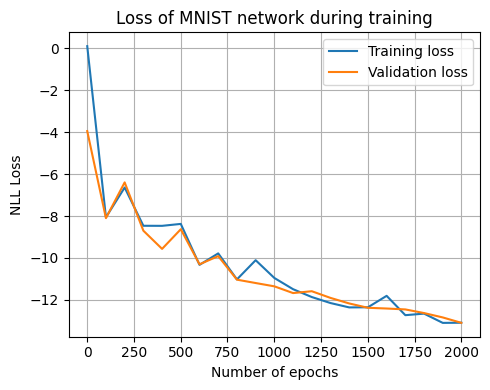

In [67]:
plt.figure(figsize=(5, 4))

plt.plot(times, loss_train, label='Training loss')
plt.plot(times, loss_test, label='Validation loss')

plt.title('Loss of MNIST network during training')
plt.xlabel('Number of epochs')
plt.ylabel('NLL Loss')

plt.grid()
# plt.ylim(0, 1e7)
plt.legend()
plt.tight_layout()
plt.show()

In [68]:
# save loss values & sigma
with open(SAVE_PATH + "/output/loss_test.txt", "w") as f:
    json.dump(loss_test, f, indent=0)

with open(SAVE_PATH + "/output/loss_train.txt", "w") as f:
    json.dump(loss_train, f, indent=0)

with open(SAVE_PATH + "/output/sigmas.txt", "w") as f:
    json.dump(sigmas, f, indent=0)

## Perform checks

### Plot code distribution

In [69]:
X, y = sir_degen_dataset.sample(10_000, labels=True)

with torch.no_grad():
    Z = sv_sir_degen(X, y).cpu()

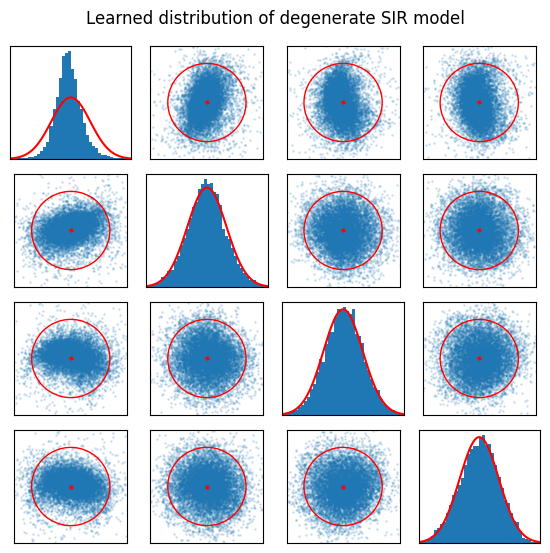

In [70]:
plot_learned_distribution(Z, f"Learned distribution of degenerate SIR model", plotsize=1.4, axis_scale=3.1)

### Plot calibration diagrams

In [71]:
X, y = sir_degen_dataset.sample(100, labels=True)
cs_degen = compute_calibration_values(sv_sir_degen, X, y, 40)

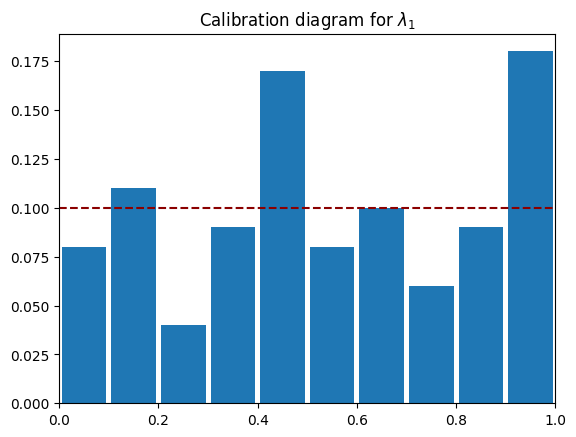

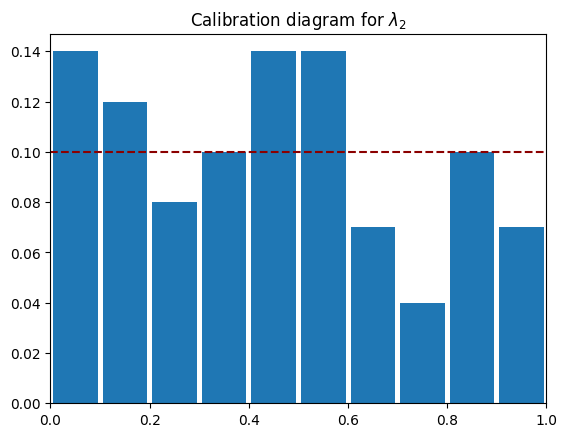

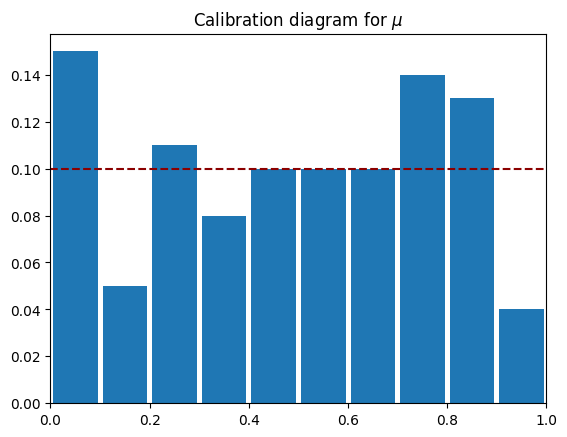

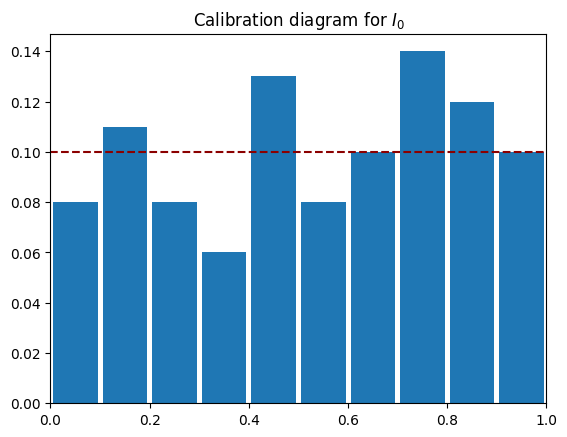

In [72]:
plot_calibration_history(cs_degen[0], 10, r"Calibration diagram for $\lambda_1$")
plot_calibration_history(cs_degen[1], 10, r"Calibration diagram for $\lambda_2$")
plot_calibration_history(cs_degen[2], 10, r"Calibration diagram for $\mu$")
plot_calibration_history(cs_degen[3], 10, r"Calibration diagram for $I_0$")

### Resimulation

In [117]:
def plot_resimulation(GT: torch.Tensor, X_resim: torch.Tensor, **kwargs):
    '''
    Plot data produced by "resimulate". The two functions are separate to allow for data cleanup of the resimulation output.
    The kwargs are passed to "plt.figure".

    ### Inputs:
    * GT: Ground-truth simulation which was resimulated. Has shape (D, 2).
    * X_resim: Resimulation data. Has shape (N_SAMPLES, D, 2).
    '''
    GT = GT.cumsum(dim=0)
    X_resim = X_resim.cumsum(dim=1)

    means = X_resim.mean(dim=0).cpu().numpy()
    quantiles = X_resim.quantile(torch.tensor([0.05, 0.95]), dim=0).cpu().numpy()
    _x = np.arange(len(GT))

    plt.figure(**kwargs)
    plt.fill_between(_x, quantiles[0, :, 0], quantiles[1, :, 0], alpha=0.2, color='orange', label='1-S 90%')
    plt.plot(_x, means[:, 0], linestyle='--', alpha=0.8, color='orange', label='1-S Mean')
    plt.plot(_x, GT[:, 0].cpu().numpy(), color='orange', label='1-S Ground truth')
    plt.fill_between(_x, quantiles[0, :, 1], quantiles[1, :, 1], alpha=0.2, color='blue', label='R 90%')
    plt.plot(_x, means[:, 1], linestyle='--', alpha=0.8, color='blue', label='R Mean')
    plt.plot(_x, GT[:, 1].cpu().numpy(), color='blue', label='R Ground truth')

    plt.xlabel("Time")
    plt.ylabel("Population fraction")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.grid()
    plt.show()

In [86]:
def resimulate(model: SurVAE, sim, Y: torch.Tensor, n_samples: int = 50, return_samples: bool = False):
    '''
    Perform a resimulation of parameters predicted by the model.

    ### Inputs:
    * model: Trained SBI SurVAE model.
    * sim: Simulation function.
    * Y: Tensor of shape (C, D), where C is the number of conditions and D is the number of parameters.
    * n_samples: Number of samples per condition.
    * return_samples: Whether to return the parameters sampled by the model.
    '''
    n_conditions = len(Y)
    X = sim(Y)

    X = X.repeat_interleave(n_samples, dim=0)
    Y_hat = model.sample(n_samples * n_conditions, X)

    X_resim: torch.Tensor = sim(Y_hat)
    X_resim = X_resim.reshape(n_conditions, n_samples, -1)

    if return_samples:
        return X_resim, Y_hat.reshape(n_conditions, n_samples, -1)
    else:
        return X_resim

In [115]:
# Resimulate for a handful of values
n_resims = 3
n_samples = 463

X, y = sir_degen_dataset.sample(n_resims, labels=True)
y_resim, X_resim = resimulate(sv_sir_degen, sir_degen_dataset._simulate, X, n_samples=n_samples, return_samples=True)

# Reshape data into dS and dR
y = y.reshape(n_resims, 100, 2)
y_resim = y_resim.reshape(n_resims, n_samples, 100, 2)

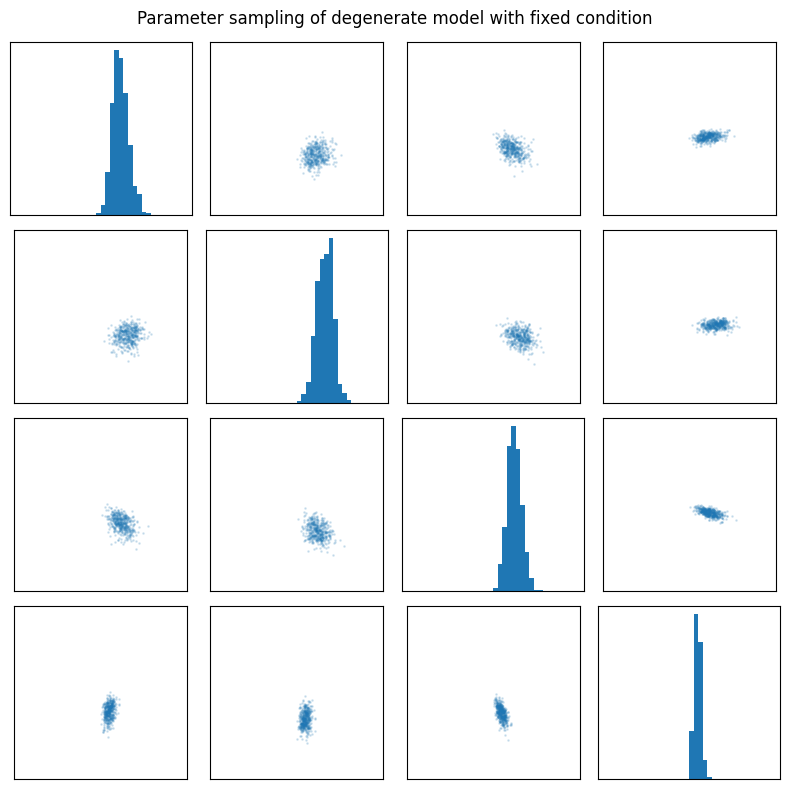

In [116]:
plot_learned_distribution(X_resim[0].cpu(), "Parameter sampling of degenerate model with fixed condition", axis_scale=1, plot_gaussian=False)

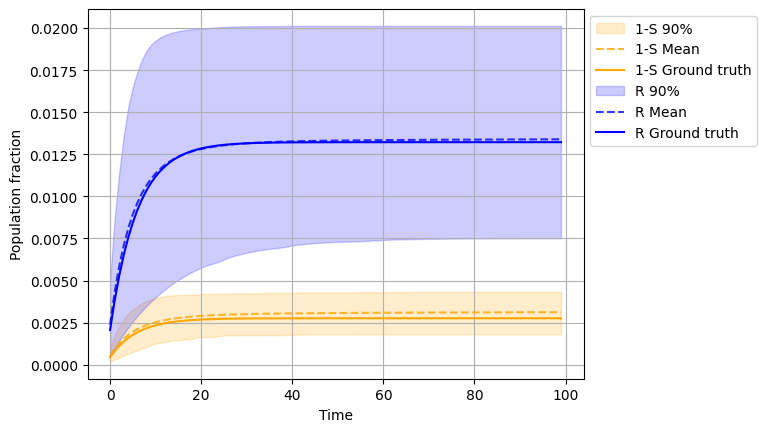

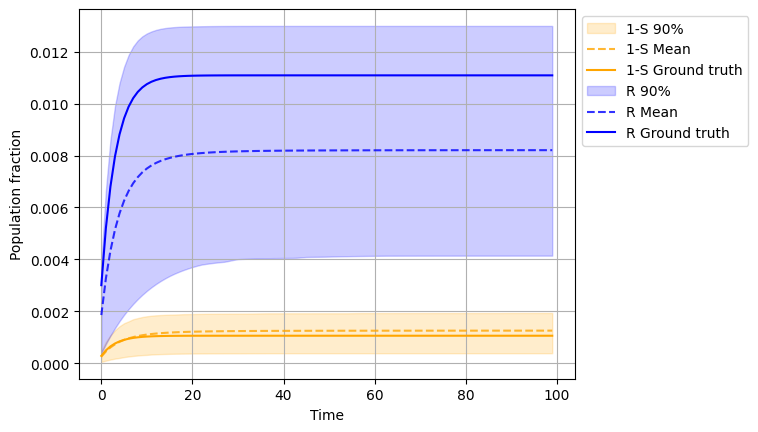

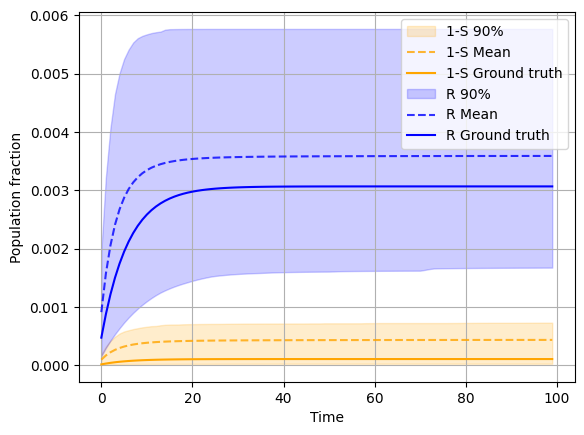

In [118]:
for _y, _y_resim in zip(y, y_resim):
    plot_resimulation(_y, _y_resim)